In [2]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss)
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    # original_loss = focal_loss(student_outputs[:,0,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0520/weights_KD_segformer_0520_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 1
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 2.4352e-04

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 548ms/step - loss: 1.2875e-04
Average validation loss: 0.7392494678497314
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 561ms/step - loss: 1.2875e-04 - val_loss: 0.7392
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 611ms/step - loss: 1.4172e-04 - val_loss: 0.7392
Average validation loss: 0.7078448534011841
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 624ms/step - loss: 1.4172e-04 - val_loss: 0.7235
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 823ms/step - loss: 1.2971e-04 - val_loss: 0.7235
Average validation loss: 0.5357141494750977
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 843ms/step - loss: 1.2971e-04 - val_loss: 0.6609
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segfo

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 880ms/step - loss: 1.5586e-04
Average validation loss: 1.0360031127929688
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 895ms/step - loss: 1.5586e-04 - val_loss: 1.0360
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 937ms/step - loss: 1.6172e-04 - val_loss: 1.0360
Average validation loss: 0.5833790898323059
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 953ms/step - loss: 1.6172e-04 - val_loss: 0.8097
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_10.pth'.
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 913ms/step - loss: 1.6262e-04 - val_loss: 0.8097
Average validation loss: 0.6487400829792023
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 926ms/step - loss: 1.6262e-04 - val_loss: 0.7560
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 920ms/step - loss: 1.6467e-04 - val_loss: 0

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 813ms/step - loss: 1.3724e-04
Average validation loss: 0.6845210293928782
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 830ms/step - loss: 1.3724e-04 - val_loss: 0.6845
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 813ms/step - loss: 1.2842e-04 - val_loss: 0.6845
Average validation loss: 0.6018364379803339
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 829ms/step - loss: 1.2842e-04 - val_loss: 0.6432
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_15.pth'.
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 809ms/step - loss: 1.2655e-04 - val_loss: 0.6432
Average validation loss: 0.7515402237574259
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 827ms/step - loss: 1.2655e-04 - val_loss: 0.6793
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 40s 830ms/step - loss: 1.2526e-

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 884ms/step - loss: 1.8005e-04
Average validation loss: 2.5381806194782257
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 895ms/step - loss: 1.8005e-04 - val_loss: 2.5382
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 29s 893ms/step - loss: 1.6550e-04 - val_loss: 2.5382
Average validation loss: 1.4045939445495605
16/16 ━━━━━━━━━━━━━━━━━━━━ 29s 906ms/step - loss: 1.6550e-04 - val_loss: 1.9714
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_20.pth'.
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 43s 846ms/step - loss: 1.6469e-04 - val_loss: 1.9714
Average validation loss: 1.2061273455619812
16/16 ━━━━━━━━━━━━━━━━━━━━ 43s 860ms/step - loss: 1.6469e-04 - val_loss: 1.7163
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weig

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 829ms/step - loss: 9.2742e-05
Average validation loss: 0.507622766494751
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 846ms/step - loss: 9.2742e-05 - val_loss: 0.5076
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 829ms/step - loss: 9.0294e-05 - val_loss: 0.5076
Average validation loss: 1.0359589815139771
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 846ms/step - loss: 9.0294e-05 - val_loss: 0.7718
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 50s 825ms/step - loss: 8.4983e-05 - val_loss: 0.7718
Average validation loss: 0.3951398432254791
20/20 ━━━━━━━━━━━━━━━━━━━━ 51s 841ms/step - loss: 8.4983e-05 - val_loss: 0.6462
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_25.pth'.
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 67s 810ms/step - loss: 8.1454e-0

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 868ms/step - loss: 5.5829e-05
Average validation loss: 1.0729686319828033
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 885ms/step - loss: 5.5829e-05 - val_loss: 1.0730
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 825ms/step - loss: 5.3584e-05 - val_loss: 1.0730
Average validation loss: 0.8572870989640554
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 841ms/step - loss: 5.3584e-05 - val_loss: 0.9651
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_30.pth'.
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 61s 826ms/step - loss: 5.2266e-05 - val_loss: 0.9651
Average validation loss: 1.226155956586202
24/24 ━━━━━━━━━━━━━━━━━━━━ 62s 842ms/step - loss: 5.2266e-05 - val_loss: 1.0521
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 82s 832ms/step - loss: 5.2906e-0

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 34s 843ms/step - loss: 9.6859e-05
Average validation loss: 0.5600158780813217
40/40 ━━━━━━━━━━━━━━━━━━━━ 34s 857ms/step - loss: 9.6859e-05 - val_loss: 0.5600
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 70s 899ms/step - loss: 8.7275e-05 - val_loss: 0.5600
Average validation loss: 1.3420849561691284
40/40 ━━━━━━━━━━━━━━━━━━━━ 71s 913ms/step - loss: 8.7275e-05 - val_loss: 0.9511
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 103s 796ms/step - loss: 8.3301e-05 - val_loss: 0.9511
Average validation loss: 1.653776752948761
40/40 ━━━━━━━━━━━━━━━━━━━━ 103s 810ms/step - loss: 8.3301e-05 - val_loss: 1.1853
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 138s 873ms/step - loss: 7.8948e-05 - val_loss: 1.1853
Average validation loss: 0.5190082520246506
40/40 ━━━━━━━━━━━━━━━━━━━━ 139s 888ms/step - loss: 7.8948e-05 - val_loss: 1.0187
Saved mod

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 40s 838ms/step - loss: 6.6121e-05
Average validation loss: 0.8841958940029144
48/48 ━━━━━━━━━━━━━━━━━━━━ 41s 852ms/step - loss: 6.6121e-05 - val_loss: 0.8842
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 81s 834ms/step - loss: 6.6792e-05 - val_loss: 0.8842
Average validation loss: 1.6972362672289212
48/48 ━━━━━━━━━━━━━━━━━━━━ 82s 848ms/step - loss: 6.6792e-05 - val_loss: 1.2907
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 121s 811ms/step - loss: 6.2262e-05 - val_loss: 1.2907
Average validation loss: 1.3330611810088158
48/48 ━━━━━━━━━━━━━━━━━━━━ 121s 825ms/step - loss: 6.2262e-05 - val_loss: 1.3048
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 161s 831ms/step - loss: 5.8057e-05 - val_loss: 1.3048
Average validation loss: 1.633802888294061
48/48 ━━━━━━━━━━━━━━━━━━━━ 162s 845ms/step - loss: 5.8057e-05 - val_loss: 1.3871
Epoch 5/1

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 47s 831ms/step - loss: 5.2467e-05
Average validation loss: 2.0120112725666592
56/56 ━━━━━━━━━━━━━━━━━━━━ 47s 845ms/step - loss: 5.2467e-05 - val_loss: 2.0120
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 94s 824ms/step - loss: 4.6084e-05 - val_loss: 2.0120
Average validation loss: 1.6275248697825841
56/56 ━━━━━━━━━━━━━━━━━━━━ 94s 838ms/step - loss: 4.6084e-05 - val_loss: 1.8198
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_70.pth'.
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 141s 832ms/step - loss: 4.3596e-05 - val_loss: 1.8198
Average validation loss: 2.0158679996218
56/56 ━━━━━━━━━━━━━━━━━━━━ 142s 846ms/step - loss: 4.3596e-05 - val_loss: 1.8851
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 188s 829ms/step - loss: 4.3556e-

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 53s 831ms/step - loss: 4.7222e-05
Average validation loss: 1.4574834033846855
64/64 ━━━━━━━━━━━━━━━━━━━━ 54s 844ms/step - loss: 4.7222e-05 - val_loss: 1.4575
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 108s 844ms/step - loss: 4.4436e-05 - val_loss: 1.4575
Average validation loss: 2.223740618675947
64/64 ━━━━━━━━━━━━━━━━━━━━ 109s 857ms/step - loss: 4.4436e-05 - val_loss: 1.8406
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 162s 825ms/step - loss: 4.2676e-05 - val_loss: 1.8406
Average validation loss: 1.8354905173182487
64/64 ━━━━━━━━━━━━━━━━━━━━ 163s 838ms/step - loss: 4.2676e-05 - val_loss: 1.8389
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 215s 825ms/step - loss: 4.0032e-05 - val_loss: 1.8389
Average validation loss: 1.9781532920897007
64/64 ━━━━━━━━━━━━━━━━━━━━ 216s 839ms/step - loss: 4.0032e-05 - val_loss: 1.8737
Epoch 5

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 59s 825ms/step - loss: 3.4752e-05
Average validation loss: 1.7093168571591377
72/72 ━━━━━━━━━━━━━━━━━━━━ 60s 838ms/step - loss: 3.4752e-05 - val_loss: 1.7093
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 120s 826ms/step - loss: 3.4235e-05 - val_loss: 1.7093
Average validation loss: 1.5547118323544662
72/72 ━━━━━━━━━━━━━━━━━━━━ 121s 839ms/step - loss: 3.4235e-05 - val_loss: 1.6320
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_90.pth'.
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 181s 829ms/step - loss: 3.4218e-05 - val_loss: 1.6320
Average validation loss: 2.093956924147076
72/72 ━━━━━━━━━━━━━━━━━━━━ 182s 842ms/step - loss: 3.4218e-05 - val_loss: 1.7860
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 241s 829ms/step - loss: 3.32

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 70s 869ms/step - loss: 3.9518e-05
Average validation loss: 2.3967597767710687
80/80 ━━━━━━━━━━━━━━━━━━━━ 71s 882ms/step - loss: 3.9518e-05 - val_loss: 2.3968
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 138s 838ms/step - loss: 3.6440e-05 - val_loss: 2.3968
Average validation loss: 2.0119983248412607
80/80 ━━━━━━━━━━━━━━━━━━━━ 139s 851ms/step - loss: 3.6440e-05 - val_loss: 2.2044
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_100.pth'.
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 207s 850ms/step - loss: 3.4656e-05 - val_loss: 2.2044
Average validation loss: 1.49147919267416
80/80 ━━━━━━━━━━━━━━━━━━━━ 208s 863ms/step - loss: 3.4656e-05 - val_loss: 1.9667
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 81s 842ms/step - loss: 3.9539e-05
Average validation loss: 1.874015039453904
96/96 ━━━━━━━━━━━━━━━━━━━━ 82s 855ms/step - loss: 3.9539e-05 - val_loss: 1.8740
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 162s 831ms/step - loss: 3.6688e-05 - val_loss: 1.8740
Average validation loss: 2.2508425191044807
96/96 ━━━━━━━━━━━━━━━━━━━━ 163s 845ms/step - loss: 3.6688e-05 - val_loss: 2.0624
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 243s 829ms/step - loss: 3.4452e-05 - val_loss: 2.0624
Average validation loss: 1.503058643390735
96/96 ━━━━━━━━━━━━━━━━━━━━ 244s 842ms/step - loss: 3.4452e-05 - val_loss: 1.8760
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_120.pth'.
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 324s 827ms/step - loss: 3.3

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 104s 867ms/step - loss: 5.3737e-05
Average validation loss: 1.8105122943719227
120/120 ━━━━━━━━━━━━━━━━━━━━ 106s 880ms/step - loss: 5.3737e-05 - val_loss: 1.8105
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 212s 888ms/step - loss: 4.6830e-05 - val_loss: 1.8105
Average validation loss: 1.7774757593870163
120/120 ━━━━━━━━━━━━━━━━━━━━ 214s 901ms/step - loss: 4.6830e-05 - val_loss: 1.7940
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_150.pth'.
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 321s 896ms/step - loss: 4.2745e-05 - val_loss: 1.7940
Average validation loss: 2.1067017485698063
120/120 ━━━━━━━━━━━━━━━━━━━━ 323s 909ms/step - loss: 4.2745e-05 - val_loss: 1.8982
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 428s 876m

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 119s 827ms/step - loss: 4.6060e-05
Average validation loss: 1.9625636223289702
144/144 ━━━━━━━━━━━━━━━━━━━━ 121s 840ms/step - loss: 4.6060e-05 - val_loss: 1.9626
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 240s 824ms/step - loss: 4.1341e-05 - val_loss: 1.9626
Average validation loss: 2.026116883589162
144/144 ━━━━━━━━━━━━━━━━━━━━ 242s 837ms/step - loss: 4.1341e-05 - val_loss: 1.9943
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 361s 826ms/step - loss: 3.8366e-05 - val_loss: 1.9943
Average validation loss: 2.751405355417066
144/144 ━━━━━━━━━━━━━━━━━━━━ 362s 840ms/step - loss: 3.8366e-05 - val_loss: 2.2467
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 482s 828ms/step - loss: 3.6527e-05 - val_loss: 2.2467
Average validation loss: 2.196294685204824
144/144 ━━━━━━━━━━━━━━━━━━━━ 484s 841ms/step - loss: 3.6527e-05 - val_los

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 132s 827ms/step - loss: 3.6680e-05
Average validation loss: 1.9943991526961327
160/160 ━━━━━━━━━━━━━━━━━━━━ 134s 840ms/step - loss: 3.6680e-05 - val_loss: 1.9944
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 262s 799ms/step - loss: 3.3088e-05 - val_loss: 1.9944
Average validation loss: 1.7290116094052792
160/160 ━━━━━━━━━━━━━━━━━━━━ 264s 811ms/step - loss: 3.3088e-05 - val_loss: 1.8617
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_200.pth'.
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 392s 798ms/step - loss: 3.1988e-05 - val_loss: 1.8617
Average validation loss: 2.1622365310788156
160/160 ━━━━━━━━━━━━━━━━━━━━ 394s 810ms/step - loss: 3.1988e-05 - val_loss: 1.9619
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 523s 809m

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 160s 802ms/step - loss: 6.0747e-05
Average validation loss: 1.7650216400623322
200/200 ━━━━━━━━━━━━━━━━━━━━ 163s 815ms/step - loss: 6.0747e-05 - val_loss: 1.7650
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 323s 798ms/step - loss: 5.2522e-05 - val_loss: 1.7650
Average validation loss: 1.8652616971731186
200/200 ━━━━━━━━━━━━━━━━━━━━ 325s 810ms/step - loss: 5.2522e-05 - val_loss: 1.8151
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 485s 801ms/step - loss: 4.6903e-05 - val_loss: 1.8151
Average validation loss: 2.082549859881401
200/200 ━━━━━━━━━━━━━━━━━━━━ 488s 814ms/step - loss: 4.6903e-05 - val_loss: 1.9043
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 648s 800ms/step - loss: 4.4524e-05 - val_loss: 1.9043
Average validation loss: 2.0045316579937933
200/200 ━━━━━━━━━━━━━━━━━━━━ 650s 813ms/step - loss: 4.4524e-05 - val_l

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 192s 802ms/step - loss: 5.0091e-05
Average validation loss: 2.158108851065238
240/240 ━━━━━━━━━━━━━━━━━━━━ 195s 814ms/step - loss: 5.0091e-05 - val_loss: 2.1581
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 393s 821ms/step - loss: 4.4803e-05 - val_loss: 2.1581
Average validation loss: 2.219140950590372
240/240 ━━━━━━━━━━━━━━━━━━━━ 396s 834ms/step - loss: 4.4803e-05 - val_loss: 2.1886
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 588s 801ms/step - loss: 4.1204e-05 - val_loss: 2.1886
Average validation loss: 2.2441973557074864
240/240 ━━━━━━━━━━━━━━━━━━━━ 591s 813ms/step - loss: 4.1204e-05 - val_loss: 2.2071
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 784s 804ms/step - loss: 3.8693e-05 - val_loss: 2.2071
Average validation loss: 1.998772465189298
240/240 ━━━━━━━━━━━━━━━━━━━━ 787s 817ms/step - loss: 3.8693e-05 - val_los

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.7744769003987312, 1.0010455229878426, 1.5528070917725563, 1.1463611033558845, 1.3442388862967491, 1.5085934307674567, 1.4432679951637981, 1.6161398401608071, 1.6539185558472362, 1.7520060694217683, 1.8299897833747998, 1.808512480020523, 1.869554608880232, 2.0145282679945233, 2.0020662960078983, 2.0179163470119237, 2.019414188367129, 2.0938473675946394]
std_val_losses =  [0.5926912228500214, 0.5292495859192974, 1.4720963345193527, 0.5025137122313907, 0.5391077397417208, 0.5551460561034516, 0.5025238000989868, 0.4215104715929411, 0.4159678109995869, 0.38761240073632847, 0.3202449294138428, 0.27189835485370006, 0.3042333857617353, 0.29503147910561184, 0.25193767270898365, 0.21338116908807847, 0.2520979994116056, 0.2466402421505399]


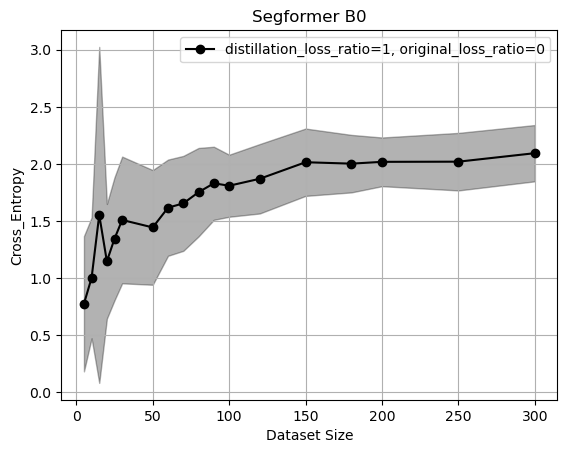

In [3]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0520')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0520_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0520_{int(teacher_ratio*100)}.png"))

plt.show()